# トーリック符号模型の量子相


In [4]:
from utility_fujii import *
from qulacs import ParametricQuantumCircuit
import scipy.optimize

import matplotlib.pyplot as plt
import numpy as np
import time 
import random
import scipy.linalg

from qulacs import QuantumState
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix
from qulacs.circuit import QuantumCircuitOptimizer

from qulacs import QuantumState
#固定ゲート
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H,S,Sdag, sqrtX,sqrtXdag,sqrtY,sqrtYdag #1量子ビット Clifford演算
from qulacs.gate import T,Tdag #1量子ビット 非Clifford演算
from qulacs.gate import CNOT, CZ, SWAP #2量子ビット演算

#パラメータ付きゲート
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算
from qulacs.gate import U1,U2,U3 #IBM Gate
from qulacs.gate import PauliRotation

from qulacs import Observable

In [5]:
def show_observable(hamiltonian):
    for j in range(hamiltonian.get_term_count()):
        pauli=hamiltonian.get_term(j)

        # Get the subscript of each pauli symbol
        index_list = pauli.get_index_list()

        # Get pauli symbols (I,X,Y,Z -> 0,1,2,3)
        pauli_id_list = pauli.get_pauli_id_list()

        # Get pauli coefficient
        coef = pauli.get_coef()

        # Create a copy of pauli operator
        another_pauli = pauli.copy()

        s = ["I","X","Y","Z"]
        pauli_str = [s[i] for i in pauli_id_list]
        terms_str = [item[0]+str(item[1]) for item in zip(pauli_str,index_list)]
        full_str = str(coef) + " " + " ".join(terms_str)
        print(full_str)

def define_Ising_Hamiltonian(operator,ListOfInt):
    nqubits = operator.get_qubit_count()
    
    for k in range(len(ListOfInt)):
        operator.add_operator(ListOfInt[k][2],"Z {0}".format(ListOfInt[k][0])+"Z {0}".format(ListOfInt[k][1]))
    return operator

#definition of interaction pattern of Ising model

def define_Jij(l_x,l_y):
    Jij = []

    for i in range(l_x -1):
        for j in range(l_y):
            #x direction
            Jij.append([i+j*l_x,i+1+j*l_x,1-2*random.random()]) 

    for i in range(l_x ):
        for j in range(l_y -1 ):        
            # y direction
            Jij.append([i+j*l_x,i+(j+1)*l_x,1-2*random.random()]) 
    return Jij

def define_Heisenberg_Hamiltonian(operator,ListOfInt):
    nqubits = operator.get_qubit_count()
    for k in range(len(ListOfInt)):
        operator.add_operator(1.0,"Z {0}".format(ListOfInt[k][0])+"Z {0}".format(ListOfInt[k][1]))
        operator.add_operator(1.0,"X {0}".format(ListOfInt[k][0])+"X {0}".format(ListOfInt[k][1])) 
        operator.add_operator(1.0,"Y {0}".format(ListOfInt[k][0])+"Y {0}".format(ListOfInt[k][1])) 
    return operator




def define_Z_field(operator):
    nqubits = operator.get_qubit_count()
    for k in range(nqubits):
        operator.add_operator(1.0,"Z {0}".format(k)) 
    return operator

def define_X_field(operator):
    nqubits = operator.get_qubit_count()
    for k in range(nqubits):
        operator.add_operator(1.0,"X {0}".format(k)) 
    return operator



def hamiltonian_ansatz(hamiltonian,driver,max_depth):
    i=0

    nqubits = hamiltonian.get_qubit_count()
    ansatz_circuit =ParametricQuantumCircuit(nqubits)


    for depth in range(max_depth):
        for j in range(hamiltonian.get_term_count()):
            pauli = hamiltonian.get_term(j)

            # Get the subscript of each pauli symbol
            index_list = pauli.get_index_list()

            # Get pauli symbols (I,X,Y,Z -> 0,1,2,3)
            pauli_id_list = pauli.get_pauli_id_list()

            ansatz_circuit.add_parametric_multi_Pauli_rotation_gate(index_list, pauli_id_list, np.pi*random.random())
            i+=1

        for j in range(driver.get_term_count()):
            pauli = driver.get_term(j)

            # Get the subscript of each pauli symbol
            index_list = pauli.get_index_list()
            # Get pauli symbols (I,X,Y,Z -> 0,1,2,3)
            pauli_id_list = pauli.get_pauli_id_list()

            ansatz_circuit.add_parametric_multi_Pauli_rotation_gate(index_list, pauli_id_list, np.pi*random.random())
            i+=1    
 #   print(ansatz_circuit.get_parameter_count())
#    print(ansatz_circuit)
    return ansatz_circuit

def cost_func_ansatz(ansatz_circuit,hamiltonian,para):
    nqubits = ansatz_circuit.get_qubit_count()
    state = QuantumState(nqubits)

    parameter_count = ansatz_circuit.get_parameter_count()



    for i in range(parameter_count):
        ansatz_circuit.set_parameter(i,para[i])
        
    ansatz_circuit.update_quantum_state(state)

    return  hamiltonian.get_expectation_value(state)



0   1   2
  3   4
5   6   7
  8   9
10  11  12

0   1   2   3
  4   5   6
7   8   9   10
  11  12  13
14  15  16  17
  18  19  20
21  22  23  24

In [6]:
length = 3
def toric_code_stabilizer(l):
    stabilizer = [[],[]]
    # plaquette
    for i in range(l-1):
        stabilizer[0].append([i,i+1,i+l])
        
    for j in range(l -2):
        for i in range(l -1):
            stabilizer[0].append([i+(2*l-1)+j*(2*l-1),i+1+(2*l-1)+j*(2*l-1),i+l+(2*l-1)+j*(2*l-1),i-(l-1)+(2*l-1)+j*(2*l-1)])

    for i in range(l - 1):
        stabilizer[0].append([(l-1)*(2*l-1)+i,(l-1)*(2*l-1)+i+1,(l-1)*(2*l-2)+i])
        
    #star
    for i in range(l-1):
        stabilizer[1].append([i*(2*l-1),i*(2*l-1)+l,i*(2*l-1)+(2*l-1)])
        
    for j in range(l-1):
        for i in range(l-2):
            stabilizer[1].append([i+1+j*(2*l-1),i+1+l-1+j*(2*l-1),i+1+l+j*(2*l-1),i+1+(2*l-1)+j*(2*l-1)])

    for i in range(l - 1):
        stabilizer[1].append([l-1+i*(2*l-1),l-1+(i+1)*(2*l-1),l-1+i*(2*l-1)+l-1])
        
    return stabilizer

In [7]:
def define_CSS_Hamiltonian(operator,ListOfInt):
    nqubits = operator.get_qubit_count()
    for k in range(len(ListOfInt[0])):
        if len(ListOfInt[0][k]) == 3:            
            operator.add_operator(-1.0,"Z {0}".format(ListOfInt[0][k][0])+" Z {0}".format(ListOfInt[0][k][1])+" Z {0}".format(ListOfInt[0][k][2]))
        if len(ListOfInt[0][k]) == 4:            
            operator.add_operator(-1.0,"Z {0}".format(ListOfInt[0][k][0])+" Z {0}".format(ListOfInt[0][k][1])+" Z {0}".format(ListOfInt[0][k][2])+" Z {0}".format(ListOfInt[0][k][3]))

    for k in range(len(ListOfInt[1])):
        if len(ListOfInt[1][k]) == 3:            
            operator.add_operator(-1.0,"X {0}".format(ListOfInt[1][k][0])+" X {0}".format(ListOfInt[1][k][1])+" X {0}".format(ListOfInt[1][k][2]))
        if len(ListOfInt[1][k]) == 4:            
            operator.add_operator(-1.0,"X {0}".format(ListOfInt[1][k][0])+" X {0}".format(ListOfInt[1][k][1])+" X {0}".format(ListOfInt[1][k][2])+" X {0}".format(ListOfInt[1][k][3]))

    return operator

def define_CSS_Hamiltonian_fields(operator,ListOfInt,h_z,h_x):
    nqubits = operator.get_qubit_count()
    for k in range(len(ListOfInt[0])):
        if len(ListOfInt[0][k]) == 3:            
            operator.add_operator(-1.0,"Z {0}".format(ListOfInt[0][k][0])+" Z {0}".format(ListOfInt[0][k][1])+" Z {0}".format(ListOfInt[0][k][2]))
        if len(ListOfInt[0][k]) == 4:            
            operator.add_operator(-1.0,"Z {0}".format(ListOfInt[0][k][0])+" Z {0}".format(ListOfInt[0][k][1])+" Z {0}".format(ListOfInt[0][k][2])+" Z {0}".format(ListOfInt[0][k][3]))

    for k in range(len(ListOfInt[1])):
        if len(ListOfInt[1][k]) == 3:            
            operator.add_operator(-1.0,"X {0}".format(ListOfInt[1][k][0])+" X {0}".format(ListOfInt[1][k][1])+" X {0}".format(ListOfInt[1][k][2]))
        if len(ListOfInt[1][k]) == 4:            
            operator.add_operator(-1.0,"X {0}".format(ListOfInt[1][k][0])+" X {0}".format(ListOfInt[1][k][1])+" X {0}".format(ListOfInt[1][k][2])+" X {0}".format(ListOfInt[1][k][3]))

    for k in range(nqubits):
        operator.add_operator(h_z,"Z {0}".format(k))
    for k in range(nqubits):    
        operator.add_operator(h_x,"X {0}".format(k))

    return operator



def CSS_state_prep(state,ListOfInt):

    for k in range(len(ListOfInt[0])):
        copy_state = state.copy()
        for i in range(len(ListOfInt[0][k])):
            Z(ListOfInt[0][k][i]).update_quantum_state(copy_state)
        state.add_state(copy_state)
        state.normalize(state.get_squared_norm())

            
    for k in range(len(ListOfInt[1])):
        copy_state = state.copy()
        for i in range(len(ListOfInt[1][k])):
            X(ListOfInt[1][k][i]).update_quantum_state(copy_state)
        state.add_state(copy_state)
        state.normalize(state.get_squared_norm())

            
    state.normalize(state.get_squared_norm())
    return state

def define_logical_operators(length):
    nqubits = length**2 + (length-1)**2
    Logi_Ope = [Observable(nqubits) for i in range(4)]
    operator = ""
    
    for k in range(length):    
        operator+=" X {0}".format(k)

#    print(operator)
    Logi_Ope[1].add_operator(1.0,operator)    
#    show_observable(Logi_Ope[1])
    
    operator = "Y 0"    
    for k in range(length-1):     
        operator+=" X {0}".format(k+1)
        operator+=" Z {0}".format((k+1)*(2*length-1))


#    print(operator)
    Logi_Ope[2].add_operator(1.0,operator) 
#    show_observable(Logi_Ope[2])

    operator = ""
    for k in range(length):    
        operator+=" Z {0}".format(k*(2*length-1))
    Logi_Ope[3].add_operator(1.0,operator)    

    return Logi_Ope

In [5]:
for i in range(4):
    show_observable(define_logical_operators(length)[i])

(1+0j) X0 X1 X2
(1+0j) Y0 X1 Z5 X2 Z10
(1+0j) Z0 Z5 Z10


In [6]:
nqubits = 2
state = QuantumState(nqubits)
ListOfInt=[[[0,1]],[[0,1]]]
CSS_state_prep(state,ListOfInt)

 *** Quantum State ***
 * Qubit Count : 2
 * Dimension   : 4
 * State vector : 
(0.707107,0)
       (0,0)
       (0,0)
(0.707107,0)

1.0
powermethod (-12.000942077439419+0j) 0.9997059682612441
powermethod (-12.000942078907466+0j) 0.9997059673053414
powermethod (-12.000942079524002+0j) 0.9997058774723457
powermethod (-12.000942080131141+0j) 0.9997059151392443
powermethod (-12.000942080195145+0j) 0.999705916521388


powermethod (-12.00373724982957+0j) 0.9988474837061362
powermethod (-12.003737270146317+0j) 0.9988473641927896
powermethod (-12.003737280364925+0j) 0.9988467579882693
powermethod (-12.0037372904209+0j) 0.9988468587495022
powermethod (-12.003737297907989+0j) 0.9988464632311476


powermethod (-12.008340427849681+0j) 0.9974584878118566
powermethod (-12.008340521658399+0j) 0.9974575391120647
powermethod (-12.008340579485461+0j) 0.9974549422791943
powermethod (-12.00834063680279+0j) 0.9974548651729368
powermethod (-12.008340692115992+0j) 0.9974520356243778


powermethod (-12.014708751373457+0j) 0.9955683079795891
powermethod (-12.014709050521152+0j) 0.9955626319406571
powermethod (-12.014709305383022+0j) 0.9955

powermethod (-12.748489360303758+0j) 0.0019949175197819307
powermethod (-12.748489399376712+0j) 0.00178469918895081


powermethod (-12.796141354491285+0j) 0.001569223431659352
powermethod (-12.79614495775052+0j) 0.0014541919303942196
powermethod (-12.79614516012522+0j) 0.001339367948878621
powermethod (-12.796145186121743+0j) 0.0011935194119754907
powermethod (-12.796145201428699+0j) 0.0009942263359645196


powermethod (-12.84516361096967+0j) 0.0008642133916708073
powermethod (-12.845167329280724+0j) 0.0007971091224082202
powermethod (-12.845167532352825+0j) 0.0007306813825598143
powermethod (-12.845167551095521+0j) 0.0006663657208754266
powermethod (-12.845167556847919+0j) 0.0005507955592916135


powermethod (-12.895558042717838+0j) 0.000472729033220352
powermethod (-12.89556187079252+0j) 0.0004322114527096623
powermethod (-12.895562056480413+0j) 0.0003924623712775215
powermethod (-12.895562070492677+0j) 0.0003574244808195386
powermethod (-12.895562072786934+0j) 0.00030256202981578296

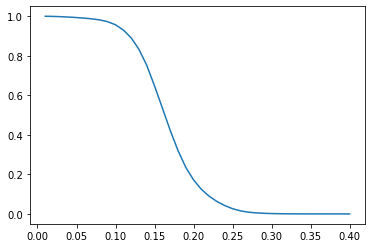

In [23]:
length =3
nqubits = length**2 + (length -1)**2
state = QuantumState(nqubits)

Logi_ope = define_logical_operators(length)

print(Logi_ope[3].get_expectation_value(state))

    
toric_Hamiltonian = Observable(length**2 + (length -1)**2)
toric_Hamiltonian = define_CSS_Hamiltonian(toric_Hamiltonian,toric_code_stabilizer(length))
#show_observable(toric_Hamiltonian)

#print("powermethod",toric_Hamiltonian.solve_ground_state_eigenvalue_by_power_method(state,20))
state = CSS_state_prep(state,toric_code_stabilizer(length))
copy_state = state.copy()
for i in range(length):
    X(i).update_quantum_state(copy_state)
    
#print(Logi_ope[3].get_expectation_value(state))
#print(Logi_ope[3].get_expectation_value(copy_state))
copy_state.multiply_coef(1.0j)
state.add_state(copy_state)
state.normalize(state.get_squared_norm())

#print(toric_Hamiltonian.get_expectation_value(state))
#print(Logi_ope[1].get_expectation_value(state))
#print(Logi_ope[2].get_expectation_value(state))
#print(Logi_ope[3].get_expectation_value(state))

gs = state.copy()
order_para = []
h = [0.01+0.01*i for i in range(40)]
for x in h:
    hamiltonian = Observable(length**2 + (length -1)**2)
    h_z = x
    h_x = x
    hamiltonian = define_CSS_Hamiltonian_fields(hamiltonian,toric_code_stabilizer(length),h_z,h_x)
#    show_observable(hamiltonian)
#    hamiltonian.solve_ground_state_eigenvalue_by_power_method(gs,10)
    for i in range(5):
        print("powermethod",hamiltonian.solve_ground_state_eigenvalue_by_arnoldi_method(gs,5),Logi_ope[2].get_expectation_value(gs))
    print("\n")
    order_para.append(Logi_ope[2].get_expectation_value(gs))
plt.plot(h,order_para)

1.0
powermethod (-24.001638163112847+0j) 0.9996089541866066
powermethod (-24.001638166557374+0j) 0.99960894299524
powermethod (-24.00163816656942+0j) 0.9996089409171897
powermethod (-24.001638166569666+0j) 0.999608940354678
powermethod (-24.001638166569723+0j) 0.999608940245452


powermethod (-24.00650663819599+0j) 0.9984710479932796
powermethod (-24.006506646862352+0j) 0.9984710450393491
powermethod (-24.006506647247036+0j) 0.9984710306868119
powermethod (-24.006506647267464+0j) 0.9984710235900439
powermethod (-24.00650664726976+0j) 0.9984710205272289


powermethod (-24.014539184494243+0j) 0.9966396755139943
powermethod (-24.01453931049064+0j) 0.9966385205424726
powermethod (-24.01453931321714+0j) 0.9966380513075802
powermethod (-24.014539313392618+0j) 0.996637976784112
powermethod (-24.01453931342315+0j) 0.9966379095212092


powermethod (-24.025673580296996+0j) 0.9941636717112763
powermethod (-24.025673793628965+0j) 0.9941613251937825
powermethod (-24.025673802715655+0j) 0.9941602772

powermethod (-25.28557199032175+0j) 0.6515594652176397
powermethod (-25.285730441492376+0j) 0.6429402449361036
powermethod (-25.285881929702224+0j) 0.6363623615928469


powermethod (-25.369908234467324+0j) 0.6249551812482566
powermethod (-25.370124672027003+0j) 0.6130168171933905
powermethod (-25.37031693363535+0j) 0.6049603983670748
powermethod (-25.3704932763098+0j) 0.5949519873838114
powermethod (-25.370658792010502+0j) 0.5874237109804996


powermethod (-25.45745108062439+0j) 0.5759149257295043
powermethod (-25.457663902128974+0j) 0.5641717155136512
powermethod (-25.457847500725414+0j) 0.5558079381234722
powermethod (-25.45801603153426+0j) 0.5458154640538994
powermethod (-25.458176546987627+0j) 0.5378206528599444


powermethod (-25.54776111215723+0j) 0.5261488905324672
powermethod (-25.547979058310325+0j) 0.5137700434381672
powermethod (-25.54816898515632+0j) 0.5041849220088448
powermethod (-25.548344549711402+0j) 0.4934736783194525
powermethod (-25.548510364671756+0j) 0.48442228893

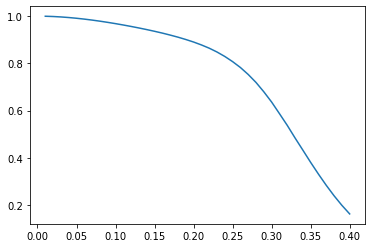

In [24]:
length =4
nqubits = length**2 + (length -1)**2
state = QuantumState(nqubits)

Logi_ope = define_logical_operators(length)

print(Logi_ope[3].get_expectation_value(state))

    
toric_Hamiltonian = Observable(length**2 + (length -1)**2)
toric_Hamiltonian = define_CSS_Hamiltonian(toric_Hamiltonian,toric_code_stabilizer(length))
#show_observable(toric_Hamiltonian)

#print("powermethod",toric_Hamiltonian.solve_ground_state_eigenvalue_by_power_method(state,20))
state = CSS_state_prep(state,toric_code_stabilizer(length))
copy_state = state.copy()
for i in range(length):
    X(i).update_quantum_state(copy_state)
    
#print(Logi_ope[3].get_expectation_value(state))
#print(Logi_ope[3].get_expectation_value(copy_state))
copy_state.multiply_coef(1.0j)
state.add_state(copy_state)
state.normalize(state.get_squared_norm())

#print(toric_Hamiltonian.get_expectation_value(state))
#print(Logi_ope[1].get_expectation_value(state))
#print(Logi_ope[2].get_expectation_value(state))
#print(Logi_ope[3].get_expectation_value(state))

gs = state.copy()
order_para = []
h = [0.01+0.01*i for i in range(40)]
for x in h:
    hamiltonian = Observable(length**2 + (length -1)**2)
    h_z = x
    h_x = x
    hamiltonian = define_CSS_Hamiltonian_fields(hamiltonian,toric_code_stabilizer(length),h_z,h_x)
#    show_observable(hamiltonian)
#    hamiltonian.solve_ground_state_eigenvalue_by_power_method(gs,10)
    for i in range(5):
        print("powermethod",hamiltonian.solve_ground_state_eigenvalue_by_arnoldi_method(gs,5),Logi_ope[2].get_expectation_value(gs))
    print("\n")
    order_para.append(Logi_ope[2].get_expectation_value(gs))
plt.plot(h,order_para)

In [44]:
length =3
max_depth = 2
nqubits = length**2 + (length -1)**2
state = QuantumState(nqubits)

Logi_ope = define_logical_operators(length)

print(Logi_ope[3].get_expectation_value(state))

    
toric_Hamiltonian = Observable(length**2 + (length -1)**2)
toric_Hamiltonian = define_CSS_Hamiltonian(toric_Hamiltonian,toric_code_stabilizer(length))
#show_observable(toric_Hamiltonian)

#print("powermethod",toric_Hamiltonian.solve_ground_state_eigenvalue_by_power_method(state,20))
state = CSS_state_prep(state,toric_code_stabilizer(length))
copy_state = state.copy()
for i in range(length):
    X(i).update_quantum_state(copy_state)
    
#print(Logi_ope[3].get_expectation_value(state))
#print(Logi_ope[3].get_expectation_value(copy_state))
copy_state.multiply_coef(1.0j)
state.add_state(copy_state)
state.normalize(state.get_squared_norm())

#print(toric_Hamiltonian.get_expectation_value(state))
#print(Logi_ope[1].get_expectation_value(state))
#print(Logi_ope[2].get_expectation_value(state))
#print(Logi_ope[3].get_expectation_value(state))

xdriver = Observable(nqubits)
define_X_field(xdriver)

zdriver = Observable(nqubits)
define_Z_field(zdriver)

initial_state = state.copy()

hamiltonian = Observable(length**2 + (length -1)**2)
x = 0.1
h_z = x
h_x = x

hamiltonian = define_CSS_Hamiltonian_fields(hamiltonian,toric_code_stabilizer(length),h_z,h_x)
circuit = hamiltonian_drivers_ansatz(toric_Hamiltonian,[xdriver,zdriver],max_depth)

#hamiltonian.solve_ground_state_eigenvalue_by_arnoldi_method(initial_state,10)

def cost(para):
    hoge =cost_func_state_ansatz(initial_state,circuit,hamiltonian,para)
    print("energy:",hoge,"mag:",Logi_ope[2].get_expectation_value(initial_state))
    return cost_func_state_ansatz(initial_state,circuit,hamiltonian,para)

init_theta_list = [random.random() for i in range(circuit.get_parameter_count())]
init_theta_list = [0 for i in range(circuit.get_parameter_count())]
cost(init_theta_list)

1.0
energy: -12.000000000000002 mag: 1.0000000000000002


-12.000000000000002

energy: -1.7252395387740038 mag: -0.013658367299375631
energy: -1.702729093989448 mag: -0.0004735459186518739
energy: -1.6011943688888304 mag: 0.021939131231550536
energy: -1.3874009600230695 mag: 0.00013240352947312237
energy: -1.3425689875766649 mag: -0.0020373465936560113
energy: -1.2310568689288963 mag: 0.014058696196700825
energy: -1.1700949806271101 mag: 0.01146691238959881
energy: -1.0531074901377464 mag: -0.026510791261741856
energy: -1.0063341334158964 mag: 0.007413380937471612
energy: -0.887926537283175 mag: -0.006051938016175712
energy: -0.7791034873431896 mag: -0.0065262100689789165
energy: -0.8305956600065015 mag: 0.010291701987826652
energy: -0.7892815995327948 mag: 0.005082695260296452
energy: -0.7069607421500169 mag: -0.011688635815047435
energy: -0.7201287518247712 mag: 0.014099857225102371
energy: -0.6417349061219326 mag: 0.007027747643949621
energy: -0.5442858495545851 mag: -0.007241608099665862
energy: -0.5187622231654312 mag: 0.004273777654606269
energy: -0.4846911

energy: -0.015992848059510595 mag: 0.014893735068006427
energy: 0.0062675694489346435 mag: -0.0008727898326075594
energy: -0.04951701500637571 mag: 0.0030639284494778083
energy: 0.008492691102270076 mag: -0.010773917059952171
energy: 0.038846421906586305 mag: -0.008165791619032525
energy: -0.031636674766943665 mag: -0.00457251275715616
energy: -0.01473596127016651 mag: 0.004412103750701017
energy: 0.00943767233839306 mag: -0.020813793909715158
energy: -0.03910260557998371 mag: 0.0003570296400624137
energy: 0.029184203896693975 mag: 0.0010450431113688471
energy: -0.04079400362405089 mag: 0.012563868181849305
energy: 0.026296071498700817 mag: -0.005540218226399236
energy: 0.03857546759731744 mag: -0.004736073710144793
energy: 0.02461105648300199 mag: 0.01037880206568377
energy: -0.02256730026762414 mag: -0.01473530695519826
energy: -0.061695726802107935 mag: -0.0012230406166069698
energy: 0.021713776064980716 mag: 0.007035462647444286
energy: 0.016735368609859334 mag: -0.0175123553888519

energy: 0.05028320845601888 mag: -0.009669489201759137
energy: -0.02545654822842854 mag: 0.005191965835293818
energy: -0.042744142635735304 mag: -0.007182127072919889
energy: -0.0384922233588067 mag: 0.006794745893552368
energy: -0.033316556627933265 mag: 0.005249213505512112
energy: -0.025475308835432267 mag: 0.0022552516596078625
energy: 0.0009673648762782993 mag: 0.00467801532531191
energy: -0.045019374714923566 mag: 0.025375835921256102
energy: 0.0008794357768407336 mag: -0.013518124747349258
energy: -0.02761754897852945 mag: 0.00020573473585296055
energy: -0.01842005006142785 mag: -0.017458511191236408
energy: -0.010236140954679663 mag: 0.00981209727236612
energy: -0.029762411087337803 mag: 0.0011370717766439591
energy: -0.0466923718105796 mag: 0.007155948339293946
energy: 0.013394502299446265 mag: 0.016513311791013754
energy: -0.0236481681234545 mag: -0.001274913232892573
energy: 0.018954274924626438 mag: 0.00268170492852616
energy: -0.024216202577072896 mag: 0.00769808222273551


energy: 0.013227184248392577 mag: 0.0060184984089651505
energy: 0.011356635724351565 mag: -0.0128221529616115
energy: 0.03941045795802332 mag: 0.0013506170702390265
energy: 0.025087638445404393 mag: 0.0068298735282702906
energy: 0.03264122538755201 mag: 0.006305804144313396
energy: 0.08007346798396475 mag: 0.0029132988493202608
energy: 0.02024478195934672 mag: 0.009884972412165259
energy: 0.022181809858428644 mag: -0.0020077544481267424
energy: 0.04600346090751902 mag: -0.0018073368361800233
energy: -0.02395261095611293 mag: 0.005421644602042293
energy: 0.02649583036601592 mag: 0.0020417968768351334
energy: -0.010574022190502314 mag: -0.0031000939764141092
energy: -0.004857426519451545 mag: 0.005010943273058418
energy: 0.06702914904495813 mag: 0.0014723967342200187
energy: -0.04391853500054748 mag: 0.014923264415401804
energy: 0.037694599707656574 mag: -0.008089765172911587
energy: -0.002434452428370607 mag: 0.009746661252039147
energy: 0.09433158486984818 mag: -0.0012771516603764645
e

energy: 0.02252170721057636 mag: -0.006437779940673998
energy: -0.0027672695821792754 mag: -0.013769990673047738
energy: 0.0026255116369732485 mag: -0.01871157843018345
energy: -0.003070422702610706 mag: 0.008173948691848202
energy: 0.06342795430969725 mag: -0.022285950550711663
energy: 0.041038761825957774 mag: 0.005590732344736502
energy: 0.0019993087890851453 mag: -0.012999307228924617
energy: 0.012553562164652572 mag: 0.0037043138485082496
energy: -0.04463704921520903 mag: 0.015988381764905794
energy: 0.08154585643242468 mag: 0.005738662769257514
energy: -0.020029258880915033 mag: -0.009479288005804117
energy: 0.026489073641579486 mag: 0.0021702808582429096
energy: 0.05442892224921327 mag: 0.009199834177043556
energy: -0.015766963479977532 mag: -0.010489259064509992
energy: 0.04177022657190152 mag: -0.011590431415077885
energy: 0.010581224325769585 mag: -0.006753637337073549
energy: 0.056288576030031845 mag: 0.014503538932100159
energy: 0.007375728312712564 mag: -0.0001589695040159

energy: -0.04122543088281115 mag: -0.013264147710677356
energy: 0.01790619753403628 mag: 0.0091329879600779
energy: 0.01198107618863009 mag: 0.012344438581266893
energy: -0.00895267214580848 mag: -0.005499474898144468
energy: 0.04481703435115189 mag: 0.015321292790710404
energy: -0.03206467884230378 mag: -0.01320002178810761
energy: -0.024323956525512242 mag: -0.005868888343720743
energy: -0.020121108460348914 mag: -0.004808221172726056
energy: -0.030482860252849388 mag: -0.00819394537285556
energy: 0.016139911078902662 mag: -0.012274999528520587
energy: 0.020183274516628335 mag: 0.004007333603679739
energy: -0.03012593806308879 mag: -0.012019319343313708
energy: 0.03526435095883887 mag: -0.005704232396554635
energy: -0.041103196489785755 mag: 0.003686845390623104
energy: 0.02462785810773999 mag: 0.003353601828848037
energy: -0.08446523218899937 mag: 0.004400721109242456
energy: 0.015968248567948918 mag: -0.022005189507183956
energy: 0.051356438956499974 mag: 0.004757817716586363
energ

energy: 0.029647450064192123 mag: -0.003557095937321025
energy: -0.013721039873285322 mag: -0.0036412044771811504
energy: 0.03447117553819331 mag: 0.007042696631601792
energy: -0.031585801117563074 mag: -0.0018559932558180076
energy: 0.01833453142274698 mag: 0.022962567516045317
energy: -0.0241700123473041 mag: -0.01989927089894614
energy: -0.03620259126247645 mag: -0.013081401540021256
energy: 0.0333417112336567 mag: 0.003142850191788615
energy: -0.014690131856452144 mag: 0.0014090666283352036
energy: 0.07027294798541622 mag: 0.013007231586241142
energy: 0.004534573432428669 mag: -0.007331700358211539
energy: -0.008189542717478146 mag: 0.012009113992871821
energy: 0.012893920818317391 mag: -0.00618591705540053
energy: -0.020521003075812415 mag: -0.008799940247402181
energy: 0.021544502997891006 mag: -0.0022794480575642094
energy: 0.0061981929604779645 mag: -0.005957236984502979
energy: 0.024143336565629746 mag: 0.021337567669313988
energy: 0.06405642156900154 mag: -0.00175989192523168

energy: -0.06461388180627001 mag: -0.013101595482577414
energy: 0.05743780195556384 mag: -0.006032040939005062
energy: 0.01107352032741752 mag: -0.015058183116192494
energy: -0.0010414496788163554 mag: -0.004366684850325132
energy: -0.04606314955960127 mag: -0.013443255016511786
energy: -0.015357406841593752 mag: 0.007520991804797162
energy: -0.06393387031675946 mag: 0.003850636549424958
energy: 0.07443297722146816 mag: -0.020457748127838942
energy: -0.021029042842130845 mag: 0.016905328929702042
energy: -0.05802097568367319 mag: 0.002641398347422767
energy: -0.001289343703258461 mag: -0.018594338812700492
energy: 0.007626850892534422 mag: 0.0008620663463949629
energy: -0.01891887376671282 mag: 0.008657070880597036
energy: 0.024646891249496636 mag: 0.005526355775078314
energy: -0.0015246635480067883 mag: -0.008561119803708135
energy: -0.018056296534878502 mag: 4.527211043984895e-05
energy: 0.019456405856636057 mag: 0.006792182210153011
energy: 0.0132858904013861 mag: 0.0125174435943681

energy: -0.0029948020508602886 mag: 0.004556489901489423
energy: -0.0284885462700804 mag: -0.006715408258026188
energy: -0.08005403791403395 mag: 0.009992328287243973
energy: -0.018785331166226327 mag: -0.00457887241177921
energy: -0.0832582511528332 mag: 0.004637212212079126
energy: -0.04229579876536072 mag: 0.0026938393011001855
energy: -0.05091169261549987 mag: 0.0061074205990412625
energy: 0.007689273871182045 mag: 0.01607429757396471
energy: 0.023967762770754266 mag: 0.007324280396569204
energy: 0.010883584467843706 mag: -0.014875254400347024
energy: -0.03098888551448087 mag: -0.020166013833269488
energy: -0.013552568726530401 mag: 0.009335551102817403
energy: -0.010452735149263466 mag: -0.0021577200245737295
energy: 0.00986506579172888 mag: 0.001000584131977381
energy: 0.03060572395852385 mag: 0.01396949206757608
energy: -0.04249642357926147 mag: -0.0071139217219888164
energy: -0.00728548259717901 mag: -0.006553430095872045
energy: 0.008216821661129584 mag: -0.0002621899856878927

energy: -0.053829992680369934 mag: 0.008039374929045691
energy: -0.013787111311642312 mag: 0.0058944482668177945
energy: -0.0050029084486127575 mag: -0.0018780392848758915
energy: 0.02218025513047659 mag: -0.03230515483801087
energy: 0.018256022784616386 mag: -0.002130725154928518
energy: 0.008978269453949363 mag: 0.013291102445328433
energy: 0.003338711033118976 mag: -0.006329116862695292
energy: -0.02400173028299105 mag: 0.00021850635746976325
energy: -0.09877662843488791 mag: 0.024892010713278463
energy: -0.0045797299332002075 mag: -0.005582404200105684
energy: 0.0025987697555014872 mag: -0.011729195963594265
energy: -0.030157423382629552 mag: 0.008599502706384371
energy: 0.01916866110511125 mag: 0.0003531255285086543
energy: -0.014453097819229713 mag: 0.010616819165880673
energy: -0.061623881304401565 mag: -0.009284698175957486
energy: -0.02683632247804611 mag: -0.010065627060297356
energy: -0.08037541575963564 mag: 0.017895579222953994
energy: 0.04884997975058805 mag: -0.007551807

energy: -0.013218270162076086 mag: 0.003773789924546575
energy: 0.04920024731794426 mag: 0.015780308413298083
energy: 0.012983182229616082 mag: 0.002688812014874892
energy: -0.018230478386919487 mag: -0.011059069156684195
energy: 0.03775018599236496 mag: -0.0059362697622882266
energy: -0.004362186383482602 mag: -0.005322636839088032
energy: -0.041302259004157 mag: -0.0005299248336738595
energy: 0.013069795186869336 mag: -0.007982907208037618
energy: 0.017476532238075534 mag: 0.0006978920189632968
energy: -0.037877217340130054 mag: 0.0064750612881706695
energy: -0.022073082934268188 mag: 0.004621902613145454
energy: 0.011486326024940284 mag: 0.004448472577331733
energy: 0.030801334060054877 mag: 0.007694637569991835
energy: 0.07868767632448091 mag: 0.003703779731327763
energy: 0.018651292190081534 mag: -0.0003365109765937906
energy: -0.024121058431707646 mag: 0.018583628795347303
energy: 0.03870953791322791 mag: 0.008625707620296347
energy: 0.0530424290551622 mag: -0.009200658922670562


energy: 0.01708037422791519 mag: -0.0110232416515043
energy: 0.0012704521854212214 mag: 0.020626178406836882
energy: 0.04490429197522516 mag: 0.0051982125528976224
energy: 0.015356520601834867 mag: 0.011276218163350261
energy: 0.014203315455287227 mag: -0.001168434135015277
energy: 0.035897462336338844 mag: 0.010310652737407415
energy: 0.02988566344340262 mag: 0.008421550127387389
energy: 0.0743304353339645 mag: -0.03078021875562935
energy: 0.007871580978923685 mag: 0.007302454255976437
energy: -0.02221767248888019 mag: -0.018353940444305383
energy: 0.04971080702892184 mag: 0.014973274181953433
energy: -0.0348019317884087 mag: 0.002114672069069041
energy: 0.05525199048067191 mag: -0.020987764812052893
energy: 0.006705256413006186 mag: -0.012084185744158194
energy: 0.021062908275689074 mag: -0.00391438880870117
energy: 0.04694136629714213 mag: -0.007343145354107298
energy: 0.05636507328775397 mag: 0.013125822957454921
energy: 0.07595826021932371 mag: -0.016623726207357744
energy: 0.0186

energy: -0.01217629930141266 mag: -0.004619741085138723
energy: 0.017145548141807118 mag: 0.01010208053266296
energy: -0.03707056541784714 mag: 0.006645362652604289
energy: 0.05472835611377832 mag: -0.012606310842349578
energy: -0.009213402462458078 mag: 0.01564087342807162
energy: -0.03264663902914448 mag: -0.0048917986249766236
energy: -0.0590820084311187 mag: -0.005426852793765111
energy: -0.0636395980950367 mag: 0.012199639827492111
energy: -0.015571794635867732 mag: -0.01607920662377142
energy: 0.02668226291348773 mag: 0.00903871912202709
energy: -0.007429676212883204 mag: -0.008601708274773301
energy: 0.07584476398837922 mag: 0.022780669998901774
energy: -0.019621325965861528 mag: -0.006508320343854923
energy: -0.01743773799243681 mag: -0.014956543369633216
energy: 0.004407556029653782 mag: -0.019276308900737987
energy: -0.003276734443103008 mag: -0.002542935348193144
energy: -0.003458081387764843 mag: -0.0019733191655015797
energy: -0.012550169398414454 mag: 0.018317757779592814

energy: -0.02626337490425961 mag: -0.009676255192186456
energy: 0.06964750478404866 mag: -0.0016998124263955159
energy: -0.04953144703872338 mag: -0.011579163887782873
energy: 0.04988697902274345 mag: 0.00284409183340569
energy: -0.05291292860331927 mag: -0.0014895103810621195
energy: -0.025875034387077413 mag: -0.015739404064431837
energy: 0.018510221139876486 mag: -0.011758455347944199
energy: -0.040860777008375475 mag: 0.009856160057924241
energy: 0.007284276085010487 mag: -0.0059695457269529255
energy: -0.017160567032909923 mag: 0.010864377264988442
energy: 0.0022176055172826578 mag: -0.010782239998041475
energy: 0.016107275641125424 mag: 0.01596998031075299
energy: -0.04526748696749056 mag: -0.006503510518902609
energy: -0.021340424699124286 mag: -0.0016918964593976259
energy: -0.019252955175303194 mag: -0.0011519472647650423
energy: 0.0065681197451354445 mag: -0.00022626858413428994
energy: 0.026790881925021 mag: -0.0029090621291231744
energy: 0.008671776653836344 mag: 0.00013787

energy: -0.05568414039688051 mag: 0.0008630336833736361
energy: -0.045008325584393334 mag: 0.01842816386029256
energy: -0.013590765728941547 mag: 0.014865292858705435
energy: -0.053357032103009086 mag: 0.0034350092022921823
energy: -0.05342766198213529 mag: -0.0011374172114679442
energy: -0.0469267815492392 mag: 0.008063585115485553
energy: -0.033800404840814584 mag: -0.0009079172894092729
energy: -0.02851994733117093 mag: 0.0069889846089218575
energy: 0.0005785892355690719 mag: -0.00624668925174641
energy: -0.04343650489705364 mag: -0.003923902987391125
energy: -0.006898095385736332 mag: 0.006923363327204299
energy: -0.04470785769181435 mag: 0.0032498698585025293
energy: -0.03433378310330906 mag: 0.010715889130957248
energy: 0.004807796049250776 mag: -0.0016813243010369875
energy: 0.012667092184741508 mag: 0.017368464262753854
energy: 0.02045802982363357 mag: 0.007949723627409441
energy: -0.10573848395986012 mag: -0.011243906286737828
energy: -0.06206831711312209 mag: 0.00651652483342

energy: -0.033988420448833684 mag: -0.0070039532457774065
energy: -0.015510659875084779 mag: 0.015347643235941143
energy: -0.03597091343222034 mag: 0.011281983926346797
energy: 0.02192065258472153 mag: 0.012639758804109938
energy: -0.07079266338023431 mag: 0.0070635278766179145
energy: 0.05585310389326781 mag: -0.007337550529922259
energy: 0.012806253870658016 mag: 0.0027585499930568537
energy: -0.026128996974599736 mag: 0.016180176564867227
energy: 0.024682897951512357 mag: 0.007305574136304845
energy: -0.046646697670447816 mag: 0.0025027880860097147
energy: 0.07321049868963715 mag: 0.020626552190909996
energy: -0.06319769708213194 mag: -0.01742790770148161
energy: 0.010974389967680196 mag: -0.001439600929948123
energy: -0.020284656701423376 mag: 0.0005565930651166601
energy: -0.025236574521114424 mag: -0.00501809938847814
energy: 0.03825324954822827 mag: -0.0019322538451797754
energy: 0.013565764411730054 mag: -0.0013723546349139054
energy: 0.004733349094114305 mag: 0.007237259688613

energy: 0.04229941192589185 mag: 0.013385699691043937
energy: 0.058717206684006894 mag: 0.01826866535657155
energy: 0.03059525117243539 mag: -0.00857864604320967
energy: -0.025386829704892363 mag: 0.0069710337133597425
energy: 0.03805858384459727 mag: 0.007156906281460755
energy: 0.002446501837827229 mag: 0.010764864373390451
energy: 0.04011985828071645 mag: 0.0057383514972080135
energy: 0.052553996431855585 mag: -0.008569868461375089
energy: 0.023855416129162005 mag: 0.002080904441948785
energy: -0.06418332650523567 mag: -0.015169976447619247
energy: 0.0372403781376274 mag: 0.0037734030861536643
energy: 0.019332144559010857 mag: 0.012434671926223054
energy: 0.019120453886984246 mag: -0.011062920254592082
energy: -0.0660633977426652 mag: -0.008269194394524218
energy: 0.0542230429199998 mag: 0.0026454971533148644
energy: 0.01359808565364306 mag: -0.004137082284698895
energy: -0.06317311265917865 mag: 0.014601300881761356
energy: -0.031227878667293086 mag: 0.008114046827684917
energy: 0.

energy: 0.007473965008435653 mag: 0.011454427971627795
energy: -0.06952508426324487 mag: 0.012733337896405657
energy: -0.006741007732234592 mag: 0.001503509843665995
energy: -0.027210405888435187 mag: -0.007391032665636782
energy: -0.030632912549450445 mag: 0.014681609980265072
energy: 0.01903717669103382 mag: -0.0041498199877508905
energy: -0.004896303020195589 mag: -0.0003773665204543557
energy: -0.0226381960895212 mag: -0.006508544066159879
energy: -0.01964082079428302 mag: 0.02156101128801509
energy: -0.08000745925348052 mag: 0.0026933623511310183
energy: -0.037002086799254125 mag: 0.002668619890374908
energy: -0.013458757594196026 mag: -0.0033282519948916412
energy: 0.017481625769475713 mag: -0.019459750133058343
energy: 0.03389665384558953 mag: 0.004589397948886143
energy: 0.02258890821780003 mag: -0.005648693696774882
energy: -0.012492021080927156 mag: -0.005365116472358449
energy: -0.003628525371751861 mag: -0.0012476016188644823
energy: -0.012407142937664064 mag: -0.0068018871

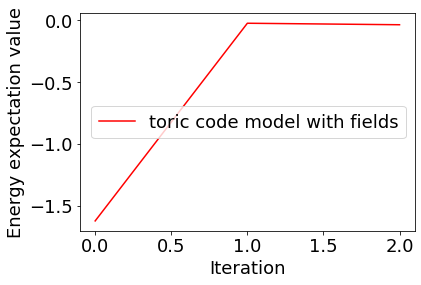

In [45]:
cost_history = []
init_theta_list = [random.random() for i in range(circuit.get_parameter_count())]
cost_history.append(cost(init_theta_list))
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}

opt = scipy.optimize.minimize(cost, init_theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="toric code model with fields")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()
plt.show()

In [40]:
opt

      fun: -11.999999999999972
 hess_inv: array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]])
      jac: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.19209290e-07,
       -1.19209290e-07, -1.19209290e-07, -1.19209290e-07, -1.19209290e-06,
       -1.19209290e-06, -1.19209290e-06, -1.31130219e-06, -1.31130219e-06,
       -1.31130219e-06, -1.31130219e-06, -1.31130219e-06, -1.31130219e-06,
       -1.31130219e-06, -1.31130219e-06, -1.43051147e-06, -1.43051147e-06,
       -1.43051147e-06, -1.78813934e-06, -1.78813934e-06, -2.14576721e-06,
       -2.26497650e-06, -2.14576721e-06, -2.26497650e-06, -2.26497650e-06,
       -2.02655792e-06, -2.02655792e-06, -2.26497650e-06, -2.26497650e-06,
       -2.26497650e-06, -2.26497650e-06, -2.50339508e-06, -2.74181366e-06,
       -2.74181366e-06, -2.74181366e-06, -2.74181366e-06, -2.861022